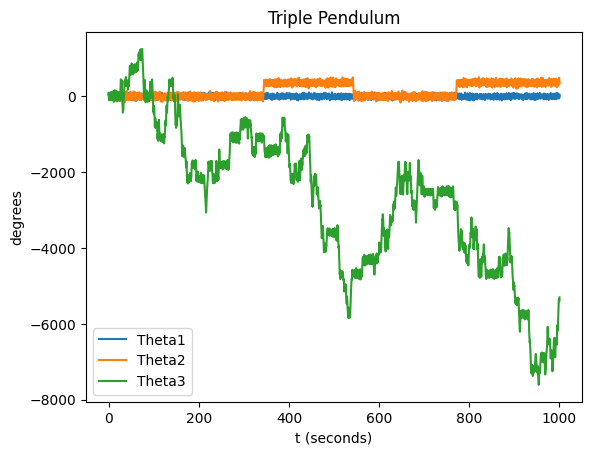

In [1]:
from __future__ import division, print_function
from math import sin, cos, pi
import numpy as np
from pylab import plot, xlabel, ylabel, show
import matplotlib.pyplot as plt
from numpy import array, arange, zeros_like
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


g = 9.81
l1 = 1
l2 = 1
l3= 1
m1 = 1.0
m2 = 1.0
m3 = 1.0

def f(q, t):
    '''Triple Pendulum equation of motion'''

    # Define relevant parameters

    # Define useful mass combinations
    m12 = m2 + m3
    m012 = m1 + m2 + m3
    mf = m012/4

    # Define useful sines
    sin0 = np.sin(q[0])
    sin1 = np.sin(q[2])
    sin2 = np.sin(q[4])

    # Define useful sine and cosine of differences
    cos01 = np.cos(q[0]-q[2])
    cos02 = np.cos(q[0]-q[4])
    cos12 = np.cos(q[2]-q[4])
    sin01 = np.sin(q[0]-q[2])
    sin02 = np.sin(q[0]-q[4])
    sin12 = np.sin(q[2]-q[4])

    # Define useful recurrent patterns
    r1 = m12*cos01*cos02 - m012*cos12
    r2 = m012 - m12*(cos01)**2
    r3 = -m012 + m3*(cos02)**2

    # Define parts of the first equation
    od1_1 = 4*m3*m12
    od1_2 = r1*cos01 + r2*cos02
    od1_3 = -g*sin2 + l1*sin02*q[1]**2 + l2*sin12*q[3]**2
    od1_4 = -g*m2*sin1 - g*m3*sin1 + l1*m2*sin01*q[1]**2 + l1*m3*sin01*q[1]**2 - l3*m3*sin12*q[5]**2
    od1_5 = -m3*m12*( -cos02 + np.cos(q[0]-2*q[2]+q[4]) )**2 * m012
    od1_6 = g*m1*sin0 + g*m2*sin0 + g*m3*sin0 + l2*m2*sin01*q[3]**2 + l2*m3*sin01*q[3]**2 + l3*m3*sin02*q[5]**2
    od1_7 = m3*r1**2 + m12*r3*r2

    # Define parts of the second equation
    od2_1 = -g*sin2 + l1*sin02*q[1]**2 + l2*sin12*q[3]**2
    od2_2 = g*m1*sin0 + g*m2*sin0 + g*m3*sin0 + l2*m2*sin01*q[3]**2 + l2*m3*sin01*q[3]**2 + l3*m3*sin02*q[5]**2
    od2_3 = -g*m2*sin1 - g*m3*sin1 + l1*m2*sin01*q[1]**2 + l1*m3*sin01*q[1]**2 - l3*m3*sin12*q[5]**2

    # Define parts of the thirds equation
    od3_1 = g*m1*sin0 + g*m2*sin0 + g*m3*sin0 + l2*m2*sin01*q[3]**2 + l2*m3*sin01*q[3]**2 + l3*m3*sin02*q[5]**2
    od3_2 = -g*sin2 + l1*sin02*q[1]**2 + l2*sin12*q[3]**2
    od3_3 = g*m2*sin1 + g*m3*sin1 - l1*m2*sin01*q[1]**2 - l1*m3*sin01*q[1]**2 + l3*m3*sin12*q[5]**2

    # ThetaDot equations
    td1 = q[1]
    td2 = q[3]
    td3 = q[5]

    # OmegaDot equations
    od1 = mf * ( od1_1 * od1_2 * od1_3 * r2 - 4 * ( -m3 * od1_2 * r1 + ( m3 * r1**2 + m12 * r3 * r2 ) * cos01 ) * od1_4 - ( od1_5 + 4*m3*r1**2 + 4*m12*r3*r2 ) * od1_6 ) / ( l1 * od1_7 * m012 * r2)
    od2 = ( -m3 * r1 * m012 * od2_1 * r2 - ( m3 * ( r1*cos01 + r2*cos02 ) * r1 - ( m3*r1**2 + m12*r3*r2 ) * cos01 ) * od2_2 + m012*r3*r2*od2_3 ) / ( l2 * od1_7 * r2 )
    od3 = -( m12 * (od1_2) * (od3_1) + m12 * m012 * (od3_2) * r2 - r1*m012 * od3_3 ) / ( l3 * ( m3*r1**2 + m12*r3*r2 ) )

    return np.array([td1, od1, td2, od2, td3, od3])

a = 0.0
b = 1000
N = 100000
h = (b - a) / N

tpoints = np.arange(a, b, h)
theta1_points = np.zeros_like(tpoints)  # Preallocate arrays with zeros
theta2_points = np.zeros_like(tpoints)
theta3_points = np.zeros_like(tpoints)

q = np.array([np.pi / 2, 0, np.pi / 3, 0, np.pi / 4, 0], float)  # Initial conditions

for i, t in enumerate(tpoints):
    theta1_points[i] = q[0] * 180 / np.pi  # Convert to degrees
    theta2_points[i] = q[2] * 180 / np.pi
    theta3_points[i] = q[4] * 180 / np.pi

    k1 = h * f(q, t)
    k2 = h * f(q + 0.5 * k1, t + 0.5 * h)
    k3 = h * f(q + 0.5 * k2, t + 0.5 * h)
    k4 = h * f(q + k3, t + h)
    q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

plt.plot(tpoints, theta1_points, label='Theta1')
plt.plot(tpoints, theta2_points, label='Theta2')
plt.plot(tpoints, theta3_points, label='Theta3')
plt.title("Triple Pendulum")
xlabel("t (seconds)")
ylabel("degrees")
plt.legend()
plt.show()



In [2]:
data = np.stack((theta1_points, theta2_points, theta3_points), axis=1)
np.save('pendulum_data.npy', data)

data = np.load('pendulum_data.npy')

# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# create the sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

def polynomial_feature_mapping(data, degree):
    poly = PolynomialFeatures(degree)
    return poly.fit_transform(data)

# Parameters
SEQ_LENGTH = 64
POLY_DEGREE = 2

# Create sequences
SEQ_LENGTH = 50
X, y = create_sequences(data, SEQ_LENGTH)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Apply polynomial feature mapping
X_train = polynomial_feature_mapping(X_train.reshape(-1, 2 * SEQ_LENGTH), POLY_DEGREE)
X_val = polynomial_feature_mapping(X_val.reshape(-1, 2 * SEQ_LENGTH), POLY_DEGREE)
X_test = polynomial_feature_mapping(X_test.reshape(-1, 2 * SEQ_LENGTH), POLY_DEGREE)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape the data for LinearRegression
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)


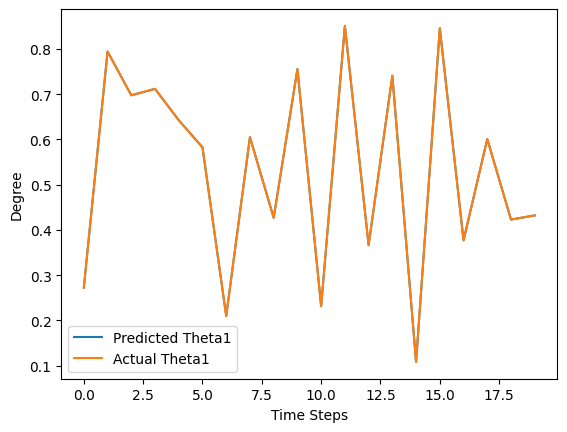

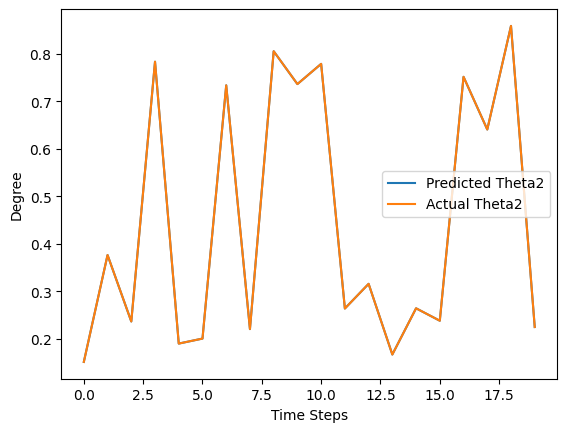

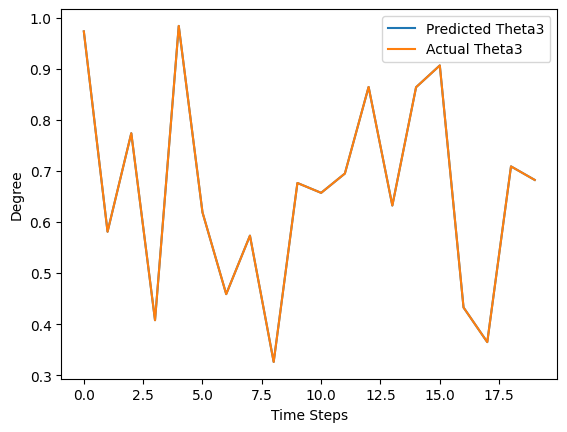

Test RMSE: 0.0000117549
Test R^2 Score: 0.999999996787791


In [3]:
# Initialize the model
model = LinearRegression()

# Early stopping parameters
patience = 15
min_delta = 0.000001

# Lists to store losses
train_losses = []
val_losses = []

# Early stopping implementation
best_val_loss = float('inf')
counter = 0

model.fit(X_train, y_train)

# Training
train_pred = model.predict(X_train)
train_loss = mean_squared_error(y_train, train_pred)
train_losses.append(train_loss)

# Validation
val_pred = model.predict(X_val)
val_loss = mean_squared_error(y_val, val_pred)
val_losses.append(val_loss)

# Early stopping
if val_loss < best_val_loss - min_delta:
    best_val_loss = val_loss
    counter = 0
else:
    counter += 1
    if counter >= patience:
        print("Early stopping")


# Evaluation on the test set
test_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, test_pred))
r2 = r2_score(y_test, test_pred)

plt.plot(test_pred[0:20, 0], label='Predicted Theta1')
plt.plot(y_test[0:20, 0], label='Actual Theta1')
plt.xlabel('Time Steps')
plt.ylabel('Degree')
plt.legend()
plt.show()

plt.plot(test_pred[0:20, 1], label='Predicted Theta2')
plt.plot(y_test[0:20, 1], label='Actual Theta2')
plt.xlabel('Time Steps')
plt.ylabel('Degree')
plt.legend()
plt.show()

plt.plot(test_pred[0:20, 2], label='Predicted Theta3')
plt.plot(y_test[0:20, 2], label='Actual Theta3')
plt.xlabel('Time Steps')
plt.ylabel('Degree')
plt.legend()
plt.show()

print(f'Test RMSE: {rmse:.10f}')
print(f'Test R^2 Score: {r2}')